# GeoPandas入門（後編）

後編になります。

この章ではEarth Engineから取得したデータを利用して地理空間情報解析について少しだけ深く掘っていきます。

この話で利用するデータは以下の通り：

- [庄内エリアのgeojson](https://drive.google.com/file/d/1BzyPKgfrJ8Jxoj_XHP6FMbSfhuJbK48T/view?usp=sharing)
- [庄内エリアの筆ポリゴン](https://drive.google.com/file/d/1JDvBmuTHz8UoR4AS6Z7JZbk0q_rfX8r8/view?usp=sharing)

ライブラリをインポートします（前編で実行した場合にはスキップです！）

In [2]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install Folium for Geographic data visualization
# !pip install folium
!pip install plotly-express
!pip install --upgrade plotly
!pip install matplotlib-scalebar
# Use EE in Python
!pip install geemap
!pip install ipygee

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 1s (2,046 kB/s)
Selecting previously unselected

     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 
  Created wheel for ipygee: filename=ipygee-0.0.14-cp37-none-any.whl size=39896 sha256=7adfbdd8aff74687fabb56e8eb90e548713e6f881893a959fc104a6ccfa74a42
  Stored in directory: /root/.cache/pip/wheels/57/f1/a2/ce9509a072ede592c0c9239ba66a1e9bb8af37bab3ca72fabc
  Created wheel for geetools: filename=geetools-0.6.9-cp37-none-any.whl size=89688 sha256=93bf2ee1fe8c5feaefbab5273088deec824ffb7876e81154cf5b352d2159f7cd
  Stored in directory: /root/.cache/pip/wheels/d8/28/1d/23473493b5e200165bc4967902c95dea8a8aa1d5384deb2759
Successfully built ipygee geetools


In [ ]:
# Colab使用時
import os
os.kill(os.getpid(), 9)

In [1]:
# Driveのマウント
# Filesからもワンクリックでマウント可能です
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ライブラリのインポートを行います。全てがインストールされていれば、エラーなく実行できます。

In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
from datetime import datetime
import geemap
from ipygee import*

## 衛星データとの組み合わせ（ラスターデータとの組み合わせ）

ここからは、衛星データを組み合わせた解析例を見てみましょう。

- eeを用いた衛星データ(MOD13Q1)の読み込み
- ベクターデータを用いた画像の切り取り
- 可視化

を行います。今回は自作のベクターデータで行っていますが、これを筆ポリゴンのような耕作地を表現するベクターデータと組み合わせることによって、収穫量の予測を行うことが可能になります。

### 座標系の変換

In [4]:
# read GeoJSON
shounai = gpd.read_file('/content/drive/MyDrive/Sorabatake/shounai.geojson')
shounai.head()

,geometry
0,"POLYGON ((139.80210 38.81213, 139.79218 38.810..."


In [5]:
shounai.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

foliumで簡単に場所を示してみます。

下のセルでは、geometryというメソッドを利用しています。GeoSeriesの属性はメソッドはほとんどがshapely由来のものです。


In [6]:
latlon = [shounai.geometry.centroid.y[0],shounai.geometry.centroid.x[0]]

m = folium.Map(latlon, zoom_start=12, control_scale=True)
folium.GeoJson(shounai).add_to(m)
m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


GeoSeriesの属性(Attributes)として以下があります：

- area
- bounds
- total_bounds
- geom_type
- is_valid

一つずつ見てみましょう。

In [7]:
# areaでは地物の面積を出すます。つまり一つ一つのgeometryが持っている面積になります
# 指定されたCRSによっては正しく面積を出すことができません。
# 正しい投影座標を選ぶことが大切です（後述します）
shounai.area

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


0    0.000179
dtype: float64

In [8]:
# boundsではx方向、y方向における最大値と最小値を出します
# これらの点を使えば、対象となるgeometryを包み込む四角形が描けます。衛星画像をダウンロードする際に指定する際に使ったりする点です。
# stackoverflowの例で見ると分かりやすいです。
# https://gis.stackexchange.com/questions/254815/simple-way-to-collect-the-sentinel-data-of-a-given-roi
shounai.bounds

,minx,miny,maxx,maxy
0,139.780555,38.786037,139.802098,38.812125


補足ですが、envelopeを利用しても同じことが可能です。envelopeでは、geometryを包む四角形を作りだすことができます。

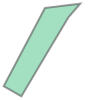

In [9]:
shounai.geometry.values[0]

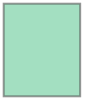

In [10]:
shounai.geometry.values[0].envelope

In [11]:
# こちらは全てのgeometryから見た最小値と最大値になります。
# envelopeの点はこちらを参照しています。
shounai.total_bounds

array([139.78055477,  38.7860372 , 139.80209827,  38.81212507])

In [12]:
# geometryのタイプを見ます
# 上で示したように、ポリゴンやポイントなどがこれにあたります。 
shounai.geometry.geom_type

0    Polygon
dtype: object

In [13]:
# geometryの形状が正しいものかの確認が行えます
# 自分で作成した、また信頼できる期間が作成したベクターファイルであれば、ここが不正なデータになることは少ないと思います
# 仮に不正なデータがあったとすれば、QGISでその対象の地物を調べてみるのが良いと思います。GeoPandasではこの不正な地物を修正することは難しいです
shounai.is_valid

0    True
dtype: bool

基本的なメソッドであるto_crsについては、後ほど確認していきましょう。

話を取得したベクターデータに戻します。

今回読み込んでいるのは、米どころであり酒どころでもある庄内の一部を切り取ったベクターデータ（shpやgeojson）になります。

ベクターデータの座標参照系(CRS)を確認しましょう。

座標参照系については、様々なところで解説を見ることができます。ここでは簡単に、座標参照系とは地理座標系(Geographic Coordinate System)と投影座標系(Projected Coordinate System)からなるものだと覚えておきましょう。

![CRS](https://www.aeroasahi.co.jp/qgis/img/crs_1.png)

<center>Source: 朝日航洋株式会社</center>

簡単な理解としては、地理座標系とは、緯度や経度のようなもので、対象の位置を示したものです。一方で投影座標系では球体を平面に置き換え、距離で位置を示したものです。そのため、ある地物（ベクターデータで表された一つ一つのオブジェクト）の面積を計算したい場合には投影座標系を利用するのが便利になります。

それでは取得したデータの空間参照系を確認してみましょう。

In [14]:
shounai.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

EPSG 4326 WGS 84となっています。

![wgs84](https://www.gsi.go.jp/common/000137139.png)

Source: https://www.gsi.go.jp/KIDS/KIDS13.html

つまり、初期の設定では、このデータがWGS84の座標系を利用していることがわかります。今回は、作成したベクターデータの面積とそこに含まれる衛星画像の値を抽出したいので、この座標系を投影座標系に置き換える必要があります。

この場合、UTM(Universal Transverse of Mercator)を利用するのが便利です。

UTM:

| ゾーン | EPSG (JGD2011) | EPSG (JGD2000) | 区域        |
| ------ | -------------- | -------------- | ----------- |
| 51     | 6688           | 3097           | 東経120-126 |
| 52     | 6689           | 3098           | 東経126-132 |
| 53     | 6690           | 3099           | 東経132-138 |
| 54     | 6691           | 3100           | 東経138-144 |
| 55     | 6692           | 3101           | 東経144-150 |

![UTB](http://upload.wikimedia.org/wikipedia/commons/d/df/横メルカトル.png)

Source: https://tmizu23.hatenablog.com/entry/20091215/1260868350

山形はUTM54に当たるため、EPSG 6691を指定すれば良いことがわかります。

In [15]:
# Convert 4326 to 6691
shounai.to_crs('epsg:6691',inplace=True)

In [16]:
# Check its crs
shounai.crs

<Projected CRS: EPSG:6691>
Name: JGD2011 / UTM zone 54N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Japan - between 138°E and 144°E, onshore and offshore.
- bounds: (138.0, 17.63, 144.0, 46.05)
Coordinate Operation:
- name: UTM zone 54N
- method: Transverse Mercator
Datum: Japanese Geodetic Datum 2011
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

WGS84からJGD2011座標系に置き換わっているのが分かります。投影座標系はUTM 54になっています。（Datumというのは測地系というものです。地理座標系のベースになっているようなものと思ってください）。

それでは、面積(ヘクタール）を計算してみましょう。

In [17]:
shounai['area_ha'] = shounai.geometry.area/10**4
shounai.head()

,geometry,area_ha
0,"POLYGON ((395996.193 4296609.728, 395133.698 4...",172.35443


約172ヘクタールであることがわかりました。

### 二つのベクターデータの結合

例えば、巨大なベクターデータを持っていたとします。地物の数が膨大にあるような場合です（または複雑）。このような際には、大量のデータを扱うため計算や描画に時間を要することがあります。

筆ポリゴンが良い例でしょう。田畑の大きさと位置を持った筆ポリゴンは非常に細かいデータの集合で描画や計算に使うには向かない場合が多いです。今回は、上で作成したポリゴンの範囲内にのみ含まれる筆ポリゴンを対象にしてみます。

つまりベースとなるポリゴンの内部に含まれている田畑を抽出するということです。

大きな地物があり、その形状が複雑であれば、そのデータをシンプルにするという手段で読み込むことができます。またベクターをラスターにしてしまい（[ラスタライズ](https://www.gis-py.com/entry/py-gdal)）、それを利用して対象となるラスター画像をくり抜くという方法もあります（基本の考えは複雑なベクターを単純にするという意味で同じですが、この方法であれば大量の地物がある場合でも対処できます。しかしデータとしては荒くなるので、そこらはトレードオフだと思います）。

山形県鶴岡市の筆ポリゴンを取得し、そのgeojsonをGeoPandasで読み込みます。

筆ポリゴンは[こちら](https://niaesvic.dc.affrc.go.jp/ja/dataset/maff_fude_pref06/resource/0dd9ca28-4e2b-4034-99a1-62f2d3f9b7be)からダウンロード可能です。

In [18]:
fudeShounai = gpd.read_file('/content/drive/MyDrive/Sorabatake/062032019_5.geojson')
fudeShounai.head()

,耕地の種類,geometry
0,畑,"POLYGON ((139.66770 38.69666, 139.66774 38.696..."
1,畑,"POLYGON ((139.63995 38.68438, 139.63997 38.684..."
2,田,"POLYGON ((139.61416 38.53564, 139.61411 38.535..."
3,畑,"POLYGON ((139.60905 38.66172, 139.60904 38.661..."
4,田,"POLYGON ((139.96073 38.66176, 139.96079 38.661..."


同様にCRSを確かめます。

In [19]:
fudeShounai.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

耕地の種類から、畑のみを抽出します。

In [20]:
fudeShounaiF = fudeShounai.loc[fudeShounai['耕地の種類'] == '畑',:]

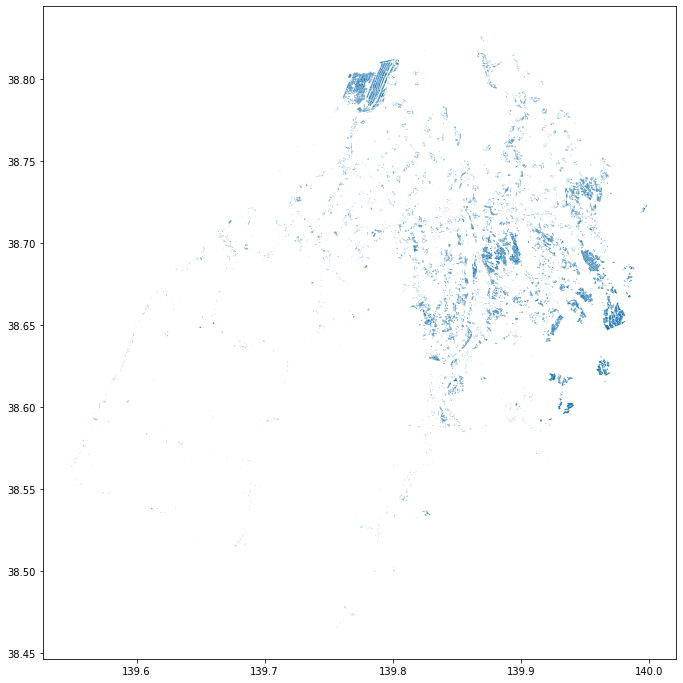

In [21]:
fudeShounaiF.plot(figsize=(12,12))
plt.show()

座標系を変換し、こちらも面積を求めてみましょう。

In [22]:
# Convert 4326 to 6691
fudeShounaiF.to_crs('epsg:6691',inplace=True)
fudeShounaiF.insert(1,'area_ha',fudeShounaiF.geometry.area/10**4)

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:1325: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [23]:
fudeShounaiF.head()

,耕地の種類,area_ha,geometry
0,畑,0.001259,"POLYGON ((384140.217 4283957.772, 384143.598 4..."
1,畑,0.001332,"POLYGON ((381707.270 4282630.742, 381708.770 4..."
3,畑,0.001430,"POLYGON ((378981.467 4280155.652, 378979.930 4..."
8,畑,0.001744,"POLYGON ((382863.495 4284297.926, 382867.634 4..."
13,畑,0.001842,"POLYGON ((382906.962 4284381.134, 382908.463 4..."


shounaiのベクター内に含まれている筆ポリゴンのみを抽出します。

In [24]:
# Reference about .overlay: https://atmamani.github.io/cheatsheets/open-geo/geopandas-3/
mergedGdf = gpd.overlay(shounai,fudeShounaiF,how='intersection')
mergedGdf['areaIntersect'] = mergedGdf['geometry'].area/10**4

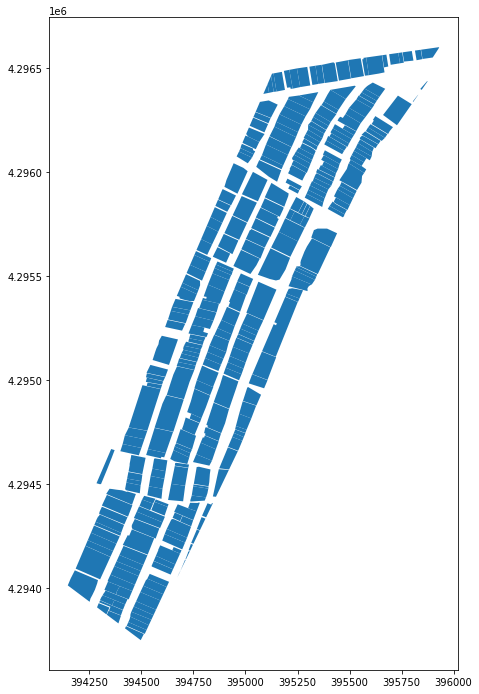

In [25]:
mergedGdf.plot(figsize=(12,12))

先ほど描画した結果と異なり、北西の一部が切り取られていることが分かります。

foliumで確かめてみます。

In [26]:
latlon = [38.7918,139.8118]
m = folium.Map(latlon,zoom_start=14, control_scale=True)
folium.GeoJson(mergedGdf).add_to(m)
m

In [27]:
mergedGdf.head()

,area_ha_1,耕地の種類,area_ha_2,geometry,areaIntersect
0,172.35443,畑,0.056522,"POLYGON ((395874.936 4296435.892, 395847.288 4...",0.025816
1,172.35443,畑,0.066764,"POLYGON ((394748.834 4294490.234, 394750.422 4...",0.066764
2,172.35443,畑,0.070572,"POLYGON ((394648.011 4294182.422, 394654.785 4...",0.070572
3,172.35443,畑,0.085913,"POLYGON ((394953.900 4294779.824, 395005.212 4...",0.085913
4,172.35443,畑,0.086753,"POLYGON ((394563.159 4294415.334, 394568.911 4...",0.086753


In [28]:
mergedGdf.areaIntersect.sum() # 合計は約108ha

108.00578337861548

結合したファイルをshpとして保存します。これは次の作業で利用します。

In [29]:
mergedGdf.drop(columns={'area_ha_1','耕地の種類','area_ha_2'},inplace=True) # 余計な列の削除
mergedGdf.to_file("/content/drive/MyDrive/Sorabatake/merged/mergedShounai.shp")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


### 衛星データの取得

今回はGoogle Earth Engineから衛星データを取得します。

取得するデータは[MODIS/Terra Vegetation Index(MOD13Q1) Version 6](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD13Q1)です。

- 16日周期で得られるデータです
- 地上分解能は250mとなります

GEEを使う前に認証を行う必要があります。認証はGEEに登録済みのユーザーアカウントで行ってください。

In [30]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=zqZvbiPU-jNp21EIpjRbipXLIQi2gV8X3Eb2ANk4BDc&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4vvIhh-OFAsfMmNOYheTndsZqx9ZXapO92Efeqjz9YoDdtPvmUijI

Successfully saved authorization token.


Successfully saved authorization token.

と出れば認証に成功です。

先ほど保存したmegedShounai.shpをGEEにインポートします。

geemapを利用することにより、簡単にローカル（またはgoogle drive上）のファイルをGEEにインポートすることが可能です。

インポートした結果も簡単に表示をすることができます。

やや脇道にそれますが、[geemap](https://geemap.org)はeeの高機能なAPIを簡単にpython上で実行できるようにしたライブラリです。開発者であるWu博士は、非常に開発頻度が高く、また利用方法に関してのドキュメントも豊富に用意してありますので、是非ご覧ください。

In [31]:
Map = geemap.Map(center=latlon, zoom=14, control_scale=True)
fudePoly = geemap.shp_to_ee('/content/drive/MyDrive/Sorabatake/merged/mergedShounai.shp')
# fudePolySimple = fudePoly.map(lambda feature: feature.simplify(maxError = 50))
Map.addLayer(fudePoly, {}, 'Shounai Hatake') # レイヤー名はShounai Hatake
Map

MOD13Q1からデータを取得します。Earth Engineでは、ラスターはImageCollection、ベクターはFeatureCollectionというコンストラクタ（メソッド）を用いて取得します。その名前の通り、取得するデータは全て大きなデータのまとまりになっています。

つまり、`ee.ImageCollection(...)`のようにすると、指定したデータでEarth Engineが持っている全てのデータ（アセット）を読み込むことになります。そのため、その後にデータを絞る必要があります。そこで用いられるのが、filterDateやfilterBoundsなどです。

In [32]:
# MODISデータの読み込み
# 今回は4月から9月までの範囲でデータを取得しています。
modis = ee.ImageCollection('MODIS/006/MOD13Q1') # IDの指定。今回はMODIS/006/MOD13Q1
modis = modis.filterDate(ee.DateRange('2019-04-01','2019-7-01')) # 2019年4月1日から2019年7月1日を取得

MOD13Q1に含まれるバンド情報を確認します。

In [33]:
modis.first().bandNames().getInfo()

['NDVI',
 'EVI',
 'DetailedQA',
 'sur_refl_b01',
 'sur_refl_b02',
 'sur_refl_b03',
 'sur_refl_b07',
 'ViewZenith',
 'SolarZenith',
 'RelativeAzimuth',
 'DayOfYear',
 'SummaryQA']

In [34]:
# 今回はNDVIのみ取得
# evi = modis.select('EVI')
ndvi = modis.select('NDVI')

NDVIのみを抽出しましょう。

スケーリングが必要なため関数を定義し、値を調整します。

詳しくは[公式のドキュメント](https://lpdaac.usgs.gov/products/mod13q1v006/)、Layersを開いてください。Scale Factorと書かれているところが利用する値となります。

In [35]:
# スケーリングのための関数
def scale_factor(image):
    return image.multiply(0.0001).copyProperties(image, ['system:time_start'])

# 取得した各々のデータに対して上の関数を実行(Mapping)
# scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [36]:
gmap = geemap.Map(center=latlon, zoom=14, control_scale=True)
gmap.addLayer(scaled_ndvi.mean().clip(fudePoly), name='Averaged NDVI',# ４月から９月までの平均値を描画。clipでfudePoly内のピクセルだけ取得
              vis_params={'min': 0,
                         'max': 1,
                         'palette': ['red', 'yellow','green']})
gmap.addLayerControl()
gmap

色が濃い部分がより緑が繁茂している状態にあると考えて良いです。同じ場所の畑ですが、値にわずかな違いがみられるのが面白いですね。

グラフも描画しましょう。こちらはipygeeを利用しています。

ipygeeではグラフを簡単に作成できるだけでなく、そのままデータフレームにできるので大変便利です。

（仮にipygeeが動かないという場合は、ここの部分を飛ばしても大丈夫です。データフレーム化もeeから出力されるデータを用いて作成することが可能です。）

In [37]:
# Shounai: MOD13Q1 EVI time series
shounai_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': fudePoly,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 250, # 250m
                                   'xProperty': 'system:time_start'})
shounai_ndvi.renderWidget(width='70%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

グラフは簡易的なものなので、実際にはmatplotlibなどを利用するのが良いです。上記で得れらたデータは簡単にテーブルデータに変更でき、この点が使いやすいと思います。

In [38]:
ndviDf = shounai_ndvi.dataframe
ndviDf

,NDVI
2019-04-07,0.345055
2019-04-23,0.367099
2019-05-09,0.436428
2019-05-25,0.459266
2019-06-10,0.336532
2019-06-26,0.501812


念のために、上の方法を利用しないテーブルデータの作成方法についても言及をします。

関心領域（この場合はfudePoly）からNDVIの平均値を取得し、その日付と平均値を取得するための関数を作成します。

In [39]:
# 関心領域のピクセルから平均値を導出
def aoi_mean(img):
  # scaleには通常、そのラスターの解像度を渡します
  # mean = img.reduceRegion(reducer=ee.Reducer.mean().unweighted(), geometry=fudePoly, scale=250).get('NDVI') # 重みなし
  # mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=fudePoly).get('NDVI') # 重みなし
  mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=fudePoly, scale=250).get('NDVI') # 重みあり
  return img.set('date', img.date().format('Y-M-d')).set('mean',mean)

reduceRegionでは、対象とする地域を絞りつつ、[reducerによる重み付け平均](https://developers.google.com/earth-engine/apidocs/ee-reducer-mean)を行っています。[ee.Reducer](https://developers.google.com/earth-engine/guides/reducers_intro)には他にも様々な種類があります。

![reduce](https://developers.google.com/earth-engine/images/Reduce_region_diagram.png)

Source: https://developers.google.com/earth-engine/guides/reducers_reduce_region

上記で得られたee.Image（各々の画像データ）に対して、メタデータを付与しています。この場合は、日付(date)と計算した平均値(mean)です。

先ほども登場したmapですが、Earth Engineでは基本的にfor文を使うことはありません。ImageCollectionは画像データの集まりなので、気持ちとしてはこれらのデータそれぞれにfor文で上の処理を行いたいところです。しかし、Earth Engineではfor文は推奨されていません。その理由として、高度な並列処理ができなくなるからだそうです。


詳しくは、[公式の情報](https://developers.google.com/earth-engine/tutorials/tutorial_js_03)をご覧ください。

In [40]:
ndvi_reduced_imgs = scaled_ndvi.map(aoi_mean)

In [41]:
nested_list = ndvi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

平均値を求めたImageCollectionから、指定した列のみを抽出したい場合、reduceColumnsを利用します。[reduceColumns](https://developers.google.com/earth-engine/apidocs/ee-imagecollection-reducecolumns)では出力は辞書型になりますので、[ee.Reducer.toList](https://developers.google.com/earth-engine/apidocs/ee-reducer-tolist)をを用いて出力をリスト型に変えています。最後に値のみを抽出し、リストの内側のみの値を取り出します。

これでデータフレームを作成する準備ができました。

In [42]:
df = pd.DataFrame(nested_list.getInfo(), columns=['date','ndvi'])
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')

In [43]:
df

,date,ndvi
0,2019-04-07,0.345055
1,2019-04-23,0.367099
2,2019-05-09,0.436428
3,2019-05-25,0.459266
4,2019-06-10,0.336532
5,2019-06-26,0.501812


描画を行います。

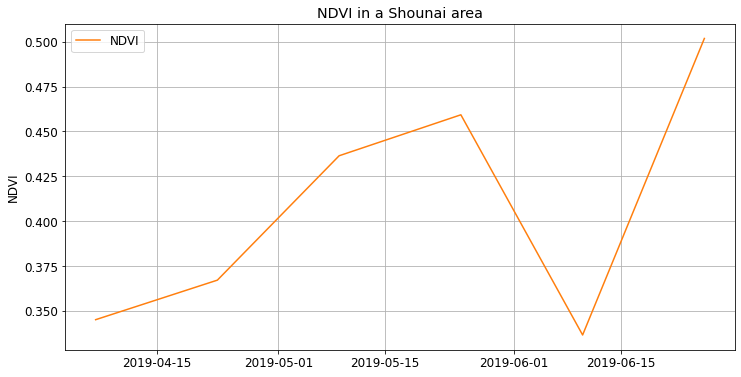

In [44]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(12, 6))

# 線の見た目調整
ax.plot(df.date, df.ndvi, color='tab:orange', label='NDVI')

# ラベルとタイトルなど
ax.set_xlabel('')
ax.set_ylabel('NDVI')
ax.set_title('NDVI in a Shounai area')
ax.grid(True)
ax.legend(loc='upper left'); # レジェンドの位置

データフレーム化できました。

やや面倒ですが、このような作業で自分の興味範囲のみの衛星画像データをデータフレームにすることができます。今回は筆ポリゴンの面積も求めていますので、収量予測のモデルが作れれば、面積あたりの収量を予測することも可能です。

### 補足

別の方法でも見ていきましょう。

まずはMOD13Q1に含まれる情報のおさらいです。

| Name              | Units   | Min    | Max   | Scale  | Wavelength           | Description                            |
| :---------------- | :------ | :----- | :---- | :----- | :------------------- | :------------------------------------- |
| `NDVI`            |         | -2000  | 10000 | 0.0001 |                      | Normalized Difference Vegetation Index |
| `EVI`             |         | -2000  | 10000 | 0.0001 |                      | Enhanced Vegetation Index              |
| `DetailedQA`      |         |        |       |        |                      | VI quality indicators                  |
| `sur_refl_b01`    |         | 0      | 10000 | 0.0001 | 645nm                | Red surface reflectance                |
| `sur_refl_b02`    |         | 0      | 10000 | 0.0001 | 858nm                | NIR surface reflectance                |
| `sur_refl_b03`    |         | 0      | 10000 | 0.0001 | 469nm                | Blue surface reflectance               |
| `sur_refl_b07`    |         | 0      | 10000 | 0.0001 | 2130nm/2105 - 2155nm | MIR surface reflectance                |
| `ViewZenith`      | Degrees | 0      | 18000 | 0.01   |                      | View zenith angle                      |
| `SolarZenith`     | Degrees | 0      | 18000 | 0.01   |                      | Solar zenith angle                     |
| `RelativeAzimuth` | Degrees | -18000 | 18000 | 0.01   |                      | Relative azimuth angle                 |
| `DayOfYear`       |         | 1      | 366   |        |                      | Julian day of year                     |
| `SummaryQA`       |         |        |       |        |                      | Quality reliability of VI pixel        |

In [45]:
# 興味範囲を抽出。全てのバンドデータを取得する
aoiInfo = modis.getRegion(fudePoly,scale = 250).getInfo()

In [48]:
allBandDf = pd.DataFrame(aoiInfo) # データフレーム作成
headers = allBandDf.iloc[0] # ヘッダ情報の取得（列名）
modisDf = pd.DataFrame(allBandDf.values[1:], columns=headers)
modisDf.head()

,id,longitude,latitude,time,NDVI,EVI,DetailedQA,sur_refl_b01,sur_refl_b02,sur_refl_b03,sur_refl_b07,ViewZenith,SolarZenith,RelativeAzimuth,DayOfYear,SummaryQA
0,2019_04_07,139.783,38.7881,1554595200000,3265,1683,4237,1000,1970,475,1645,4797,3075,12132,103,1
1,2019_04_23,139.783,38.7881,1555977600000,3718,1939,4168,918,2005,467,1344,4807,2527,12230,119,1
2,2019_05_09,139.783,38.7881,1557360000000,4582,3476,2116,1141,3071,805,1769,3047,2468,-3450,143,0
3,2019_05_25,139.783,38.7881,1558742400000,4326,3198,2116,1307,3300,742,1814,2052,2296,-3259,150,0
4,2019_06_10,139.783,38.7881,1560124800000,4289,2750,2062,792,1982,789,1423,1361,1961,14467,171,3


このように対象領域の全てのバンドデータを取得することも可能です。

下のように関数を定義すれば、より簡単に任意のバンドデータからデータフレームを作成することができます。

In [49]:
# Reference: https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard
# list_of_bandsにはバンド（波長）のデータを入れる
def ee_array_to_df(arr, list_of_bands):
    """ee.Image.getRegion array to pandas.DataFrameへ変換"""
    df = pd.DataFrame(arr)

    # ヘッダ追加
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # 緯度経度とtime、さらに選択したバンド情報を選択。加えて欠損値の削除する
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # バンドデータをnumericへ
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # timeをdatetime型に変更
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # 対象のバンド情報とtime, datetimeの列のみを残す
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [50]:
lst_df_modis = ee_array_to_df(aoiInfo,['NDVI','EVI'])
lst_df_modis.NDVI = lst_df_modis.NDVI.multiply(0.0001)
lst_df_modis.EVI = lst_df_modis.EVI.multiply(0.0001)

重みなし平均の結果は以下の通りです。

In [51]:
lst_df_modis.groupby('datetime').mean()

,NDVI,EVI
datetime,,
2019-04-07,0.341122,0.179365
2019-04-23,0.368548,0.205935
2019-05-09,0.437265,0.311683
2019-05-25,0.461587,0.304983
2019-06-10,0.344904,0.243726
2019-06-26,0.493596,0.372170


modisDfをGeoDataFrameに変更しましょう。

In [52]:
modisGdf = gpd.GeoDataFrame(
    modisDf, geometry=gpd.points_from_xy(modisDf.longitude, modisDf.latitude),crs={'init': 'epsg:4326'})

# 日付の列を追加
modisGdf['date'] = pd.to_datetime(modisGdf.id,format='%Y_%m_%d')
ndviGdf = modisGdf.loc[:,['date','NDVI','geometry']].copy()
ndviGdf['scaledNdvi'] = ndviGdf.NDVI.astype('int64').multiply(0.0001)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [53]:
ndviGdf.head()

,date,NDVI,geometry,scaledNdvi
0,2019-04-07,3265,POINT (139.78347 38.78813),0.3265
1,2019-04-23,3718,POINT (139.78347 38.78813),0.3718
2,2019-05-09,4582,POINT (139.78347 38.78813),0.4582
3,2019-05-25,4326,POINT (139.78347 38.78813),0.4326
4,2019-06-10,4289,POINT (139.78347 38.78813),0.4289


In [54]:
ndviGdf.geometry.unique()

<GeometryArray>
Length: 23, dtype: geometry

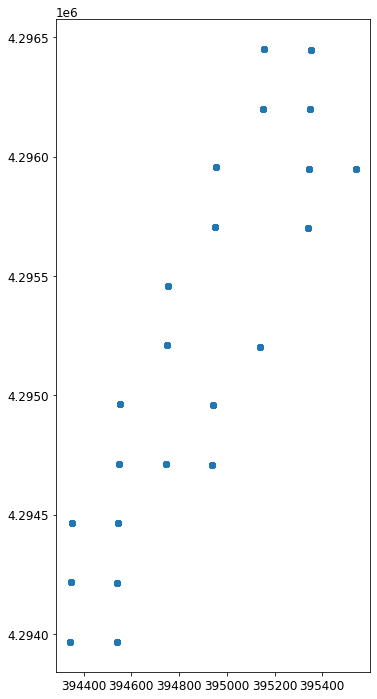

In [88]:
ndviGdf.plot(figsize=(6,12))

getRegionでscaleを250mにした結果、関心領域から23点が選ばれていることがわかります。fudePolyはmergedGdfから作成したので、302個の図形（地物）から成っています。

実はここらの処理はあまりよくわかっていないのですがscaleにはかなり揺らぎがあり、基本的に画像データの分解能より余程小さくしないかぎり、参照点の数は増えません。

関心領域全体の平均を計算するという点において、ここの数は平均に影響をしてきません、あまり神経質にならなくてよいかと思います（重みを考慮すると変わります）。

またポリゴン一つ一つの値を見たいという場合にはさらに複雑な処理が必要になります（ここでは触れませんが）。

参照系を変更し、どの位置に参照点があるのかを確かめます。

In [55]:
ndviGdf = ndviGdf.to_crs('epsg:6691')

ポイントデータになっていますので（reducerを使ってまとめたため）、ポイントからポリゴン（四角形）を作成しましょう。

In [56]:
from shapely.geometry import Point

# Buffer the points using a square cap style
# Note cap_style: round = 1, flat = 100, square = 3
ndviGdf['buffer'] = ndviGdf.geometry.buffer(100, cap_style = 3) # 100m buffer

描画してみます。

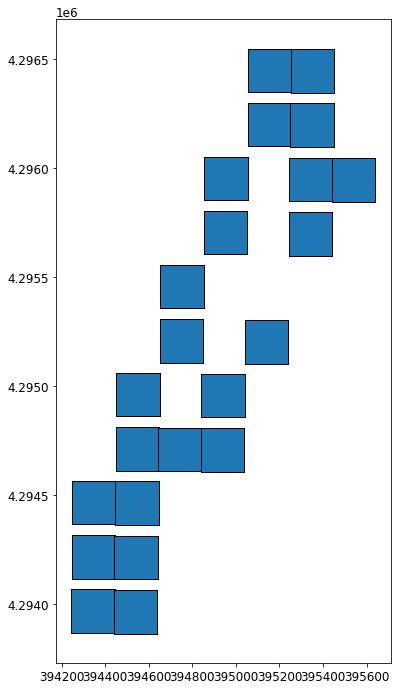

In [87]:
ndviGdf.loc[:,'buffer'].plot(figsize=(6,12),edgecolor='k')

EEはいろいろと深く掘らないと、わからないことも多いです。上のような処理で問題がある場合には、くり抜いた画像をtiffで出力し、その画像に対してはrasterstatsなどでゾーン統計をとるという方法もあります（関心領域内の平均や和などは変わりません）。

是非いろいろと遊んでみてください。

次回はゾーン統計について、さらに深く学んでいきましょう。

参考文献

- [MODIS Vegetation Indices: a GEE Approach](https://towardsdatascience.com/modis-vegetation-indices-a-gee-approach-f48e1259e462)はNDVIの取得、グラフの書き方で参考になります。
- [GeoSpatial analysis in Python and Jupyter Notebooks](https://towardsdatascience.com/geospatial-analysis-in-python-and-jupyter-notebooks-f90de25b0777)はKeplrGLを利用した方法の参考になります。bufferを利用した解析の参考にもなります。
- [Automating GIS and remote sensing workflows with open python libraries](https://towardsdatascience.com/automating-gis-and-remote-sensing-workflows-with-open-python-libraries-e71dd6b049ee)では、overlayによるベクターデータの切り取り方法やゾーン統計について詳しいです。

以上でGeoPandas入門（後編）も終わります。

今回はPythonでの紹介でしたので、ee+geemapを中心とした紹介になりました。

RでEEを利用する場合には、[rgee](https://github.com/r-spatial/rgee)があります。こちらもかなり便利になっていますので、是非活用してください。

## 汎用的な参考文献

以下はよく利用する地理空間解析のサイトです。辞書的に使えます。

- [neon](https://www.neonscience.org/data-samples/data/spatial-data-maps)
- [Earth Lab](https://www.earthdatascience.org/)
- [Automating GIS Process](https://automating-gis-processes.github.io/site/)

こちらはライブラリ関連

- [geemap](https://geemap.org)
- [ee](https://developers.google.com/earth-engine/guides/python_install)